# 03-email_categorization [enron]

* __Status__ : In progress
* __Dataset__ : Enron with Categories [enron1_with_labels_1_of_6.csv]
* __Source__ : Enron Email Dataset [https://data.world/brianray/enron-email-dataset]
* __Labeled__ : Yes. Categories retreivied from: [https://bailando.berkeley.edu/enron/enron_categories.txt]

## 📚 **Import libraries**

In [2]:
import os, sys, email
import numpy as np 
import pandas as pd
import requests
import io
import re

In [3]:
# Load the email dataset into a pandas dataframe
emails_df = pd.read_csv('https://raw.githubusercontent.com/brindasachi97/Enron-Email-Classification/master/combinedDS.csv')

## 🧹 **Quick preprocessing**

In [4]:
def clean_column(column):
    if isinstance(column, pd.Series):
        # Define the pattern to match and remove
        pattern = r'\r\n'

        # Use the sub function from the re library to remove the pattern
        cleaned_column = column.apply(lambda x: re.sub(pattern, '', str(x)))
    
        return cleaned_column
    else:
        # If the input is a single string, remove the pattern directly
        pattern = r'\r\n'
        cleaned_column = re.sub(pattern, '', str(column))
        return cleaned_column

# Load the email dataset into a pandas dataframe
emails_df = pd.read_csv('https://raw.githubusercontent.com/brindasachi97/Enron-Email-Classification/master/combinedDS.csv')

# Clean each column in the dataframe
for column in emails_df.columns:
    emails_df[column] = clean_column(emails_df[column])

# Save the cleaned dataframe to a new CSV file
emails_df.to_csv('cleaned_emails.csv', index=False)


In [5]:
# Clean each column in the dataframe
for column in emails_df.columns:
    emails_df[column] = clean_column(emails_df[column])

In [6]:
emails_df=emails_df[['Date:', 'From:', 'To:', 'Subject:','MessContents', 'category']]

In [7]:
emails_df

,Date:,From:,To:,Subject:,MessContents,category
0,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",steven.kean@enron.com,wade.cline@enron.com,Re: Job Titles and Job Banding,Thanks for your message. I do think we need to...,1
1,"Mon, 14 Aug 2000 01:55:00 -0700 (PDT)",steven.kean@enron.com,rosalee.fleming@enron.com,CFTC Reauthorization,Background information. I'd like to talk to K...,1
2,"Wed, 6 Jun 2001 06:13:00 -0700 (PDT)",miyung.buster@enron.com,"ann.schmidt@enron.com, bryan.seyfried@enron.c...",Energy Issues,"Please see the following articles:Sac Bee, Wed...",1
3,"Mon, 15 Oct 2001 12:43:02 -0700 (PDT)",john.shelk@enron.com,"richard.shapiro@enron.com, d..steffes@enron.c...",FW: Michael Travieso's testimony,\nBelow is a link to the prepared testimony of...,1
4,"Fri, 2 Mar 2001 04:37:00 -0800 (PST)",steven.kean@enron.com,mark.muller@enron.com,Enron Opportunity,any interest?\n----- Forwarded by Steven J Kea...,1
...,...,...,...,...,...,...
1704,"Mon, 18 Jun 2001 06:30:00 -0700 (PDT)",steven.kean@enron.com,nan,nan,nan,8
1705,"Mon, 18 Sep 2000 10:30:00 -0700 (PDT)",richard.sanders@enron.com,nan,nan,nan,8
1706,"Mon, 16 Oct 2000 02:55:00 -0700 (PDT)",steven.kean@enron.com,cynthia.sandherr@enron.com,Dow Jones Reports that PG&E Buys Forward for ...,----- Forwarded by Steven J Kean/NA/Enron on 1...,8
1707,"Tue, 15 Jul 1997 01:00:00 -0700 (PDT)",steven.kean@enron.com,nan,nan,nan,8


In [8]:
# Save the cleaned dataframe to a new CSV file
emails_df.to_csv('cleaned_emails.csv', index=False)

In [9]:
emails_df.columns = [re.sub(r':', '', col.lower()) for col in emails_df.columns]

In [10]:
emails_df['date'] = emails_df['date'].str.replace('Date: ', '')

In [11]:
# Remove the "(TimezoneName)" suffix from the date column
emails_df['date'] = emails_df['date'].str.replace(r'\s+\(\w+\)$', '')

/var/folders/h5/87n9sw2x5j5cbsyb3dw7_4mm0000gn/T/ipykernel_99326/3295561689.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  emails_df['date'] = emails_df['date'].str.replace(r'\s+\(\w+\)$', '')


In [12]:
emails_df['date'] = emails_df['date'].apply(lambda x: ' '.join(x.split()[:5]))

In [13]:
emails_df['date'] = emails_df['date'].apply(lambda x: ' '.join(x.split()[1:]))

In [14]:
emails_df['date'] = pd.to_datetime(emails_df['date'])

In [15]:
emails_df.rename(columns={'messcontents':'body', 'subject':'header'}, inplace=True)

In [16]:
elements_to_drop = ['Message-ID:', 'Date:', 'From:', 'To:', 'Subject:', 'Cc:', 'Mime-Version:',
 'Content-Type:', 'Content-Transfer-Encoding:', 'Bcc:', 'X-From:', 'X-To:', 'X-cc:', 'X-bcc:',
 'X-Folder:', 'X-Origin:', 'X-FileName:', 'cc', '\t', '--', 'Sent', ' --', '-', '/', '\n', 'Re:', 'FW:']

In [17]:
for element in elements_to_drop:
    emails_df['header'] = emails_df['header'].replace(element, '', regex=True)
    emails_df['body'] = emails_df['body'].replace(element, '', regex=True)

In [18]:
emails_df['header'] = emails_df['header'].str.lower()
emails_df['body'] = emails_df['body'].str.lower()

In [19]:
emails_df

,date,from,to,header,body,category
0,1979-12-31 16:00:00,steven.kean@enron.com,wade.cline@enron.com,job titles and job banding,thanks for your message. i do think we need to...,1
1,2000-08-14 01:55:00,steven.kean@enron.com,rosalee.fleming@enron.com,cftc reauthorization,background information. i'd like to talk to k...,1
2,2001-06-06 06:13:00,miyung.buster@enron.com,"ann.schmidt@enron.com, bryan.seyfried@enron.c...",energy issues,"please see the following articles:sac bee, wed...",1
3,2001-10-15 12:43:02,john.shelk@enron.com,"richard.shapiro@enron.com, d..steffes@enron.c...",michael travieso's testimony,below is a link to the prepared testimony of m...,1
4,2001-03-02 04:37:00,steven.kean@enron.com,mark.muller@enron.com,enron opportunity,any interest? forwarded by steven j keannaenro...,1
...,...,...,...,...,...,...
1704,2001-06-18 06:30:00,steven.kean@enron.com,nan,nan,nan,8
1705,2000-09-18 10:30:00,richard.sanders@enron.com,nan,nan,nan,8
1706,2000-10-16 02:55:00,steven.kean@enron.com,cynthia.sandherr@enron.com,dow jones reports that pg&e buys forward for ...,forwarded by steven j keannaenron on 10162000...,8
1707,1997-07-15 01:00:00,steven.kean@enron.com,nan,nan,nan,8


In [20]:
emails_df.dropna(inplace=True)

In [21]:
emails_df.to_csv('emails_df.csv', index=False)

## Quick EDA 🕵

In [22]:
value_counts = emails_df['category'].value_counts()

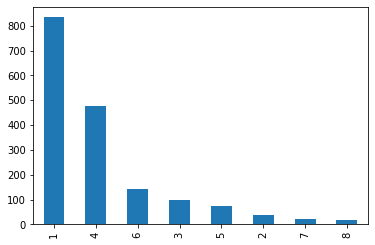

In [23]:
import matplotlib.pyplot as plt
value_counts.plot(kind='bar')
plt.show()

In [24]:
emails_df.nunique()

date        1609
from         175
to           686
header      1155
body        1500
category       8
dtype: int64

In [25]:
emails_df['category'].value_counts()

1    834
4    476
6    143
3    100
5     74
2     36
7     21
8     18
Name: category, dtype: int64

In [26]:
round((emails_df['category'].value_counts()) / (emails_df.shape[0])*100,2)

1    49.00
4    27.97
6     8.40
3     5.88
5     4.35
2     2.12
7     1.23
8     1.06
Name: category, dtype: float64

In [27]:
for col in emails_df.columns:
    print(col)
    count = (emails_df[col].astype(str) == 'nan').sum()
    print(count)

date
0
from
0
to
134
header
134
body
145
category
0


In [28]:
emails_df = emails_df.replace({"nan": np.nan})

In [29]:
emails_df.isna().sum()

date          0
from          0
to          134
header      134
body        145
category      0
dtype: int64

In [30]:
emails_df

,date,from,to,header,body,category
0,1979-12-31 16:00:00,steven.kean@enron.com,wade.cline@enron.com,job titles and job banding,thanks for your message. i do think we need to...,1
1,2000-08-14 01:55:00,steven.kean@enron.com,rosalee.fleming@enron.com,cftc reauthorization,background information. i'd like to talk to k...,1
2,2001-06-06 06:13:00,miyung.buster@enron.com,"ann.schmidt@enron.com, bryan.seyfried@enron.c...",energy issues,"please see the following articles:sac bee, wed...",1
3,2001-10-15 12:43:02,john.shelk@enron.com,"richard.shapiro@enron.com, d..steffes@enron.c...",michael travieso's testimony,below is a link to the prepared testimony of m...,1
4,2001-03-02 04:37:00,steven.kean@enron.com,mark.muller@enron.com,enron opportunity,any interest? forwarded by steven j keannaenro...,1
...,...,...,...,...,...,...
1704,2001-06-18 06:30:00,steven.kean@enron.com,NaN,NaN,NaN,8
1705,2000-09-18 10:30:00,richard.sanders@enron.com,NaN,NaN,NaN,8
1706,2000-10-16 02:55:00,steven.kean@enron.com,cynthia.sandherr@enron.com,dow jones reports that pg&e buys forward for ...,forwarded by steven j keannaenron on 10162000...,8
1707,1997-07-15 01:00:00,steven.kean@enron.com,NaN,NaN,NaN,8


In [31]:
emails_df.to_csv('emails_df.csv', index=False)

## Categorization supervised model 🧑‍🏫

In [38]:
emails_for_cat = emails_df.copy()

In [39]:
emails_for_cat = emails_for_cat.fillna("")

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(emails_for_cat["body"], emails_for_cat["category"], test_size=0.2)

In [41]:
emails_for_cat

,date,from,to,header,body,category
0,1979-12-31 16:00:00,steven.kean@enron.com,wade.cline@enron.com,job titles and job banding,thanks for your message. i do think we need to...,1
1,2000-08-14 01:55:00,steven.kean@enron.com,rosalee.fleming@enron.com,cftc reauthorization,background information. i'd like to talk to k...,1
2,2001-06-06 06:13:00,miyung.buster@enron.com,"ann.schmidt@enron.com, bryan.seyfried@enron.c...",energy issues,"please see the following articles:sac bee, wed...",1
3,2001-10-15 12:43:02,john.shelk@enron.com,"richard.shapiro@enron.com, d..steffes@enron.c...",michael travieso's testimony,below is a link to the prepared testimony of m...,1
4,2001-03-02 04:37:00,steven.kean@enron.com,mark.muller@enron.com,enron opportunity,any interest? forwarded by steven j keannaenro...,1
...,...,...,...,...,...,...
1704,2001-06-18 06:30:00,steven.kean@enron.com,,,,8
1705,2000-09-18 10:30:00,richard.sanders@enron.com,,,,8
1706,2000-10-16 02:55:00,steven.kean@enron.com,cynthia.sandherr@enron.com,dow jones reports that pg&e buys forward for ...,forwarded by steven j keannaenron on 10162000...,8
1707,1997-07-15 01:00:00,steven.kean@enron.com,,,,8


In [42]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

clf = SVC()
clf.fit(X_train_counts, y_train)
y_pred = clf.predict(X_test_counts)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5102639296187683


## Let's give Melusine a shot 🥃

In [226]:
emails_for_melu = emails_df.copy()

In [270]:
#!pip install melusine

In [228]:
import melusine

In [232]:
from melusine.summarizer.keywords_generator import KeywordsGenerator
from melusine.nlp_tools.tokenizer import Tokenizer

In [236]:
tokenizer = Tokenizer(input_column='body')
# Create the 'tokens' column
emails_for_melu = tokenizer.fit_transform(emails_for_melu)

keywords_generator = KeywordsGenerator(n_max_keywords=5, stopwords=['like'])
# Fit keyword generator on the text data corpus (using the tokens column)
keywords_generator.fit(emails_for_melu)
# Extract relevant keywords
keywords_generator.transform(emails_for_melu)

,date,from,to,header,body,category,tokens,keywords
0,1979-12-31 16:00:00,steven.kean@enron.com,wade.cline@enron.com,job titles and job banding,thanks for your message. i do think we need to...,1,"[thanks, for, your, message, i, do, think, we,...","[flag_name, enron, ees, happy, here]"
1,2000-08-14 01:55:00,steven.kean@enron.com,rosalee.fleming@enron.com,cftc reauthorization,background information. i'd like to talk to k...,1,"[background, information, i, to, talk, to, fla...","[flag_name, ees, enron, ect, com]"
2,2001-06-06 06:13:00,miyung.buster@enron.com,"ann.schmidt@enron.com, bryan.seyfried@enron.c...",energy issues,"please see the following articles:sac bee, wed...",1,"[please, see, the, following, articles, sac, b...","[flag_name, com, test, testing, amendment]"
3,2001-10-15 12:43:02,john.shelk@enron.com,"richard.shapiro@enron.com, d..steffes@enron.c...",michael travieso's testimony,below is a link to the prepared testimony of m...,1,"[below, is, a, link, to, the, prepared, testim...","[the, testimony, flag_name, counsel, htm]"
4,2001-03-02 04:37:00,steven.kean@enron.com,mark.muller@enron.com,enron opportunity,any interest? forwarded by steven j keannaenro...,1,"[flag_name, interest, forwarded, by, flag_name...","[flag_name, enron, ees, happy, www]"
...,...,...,...,...,...,...,...,...
1704,2001-06-18 06:30:00,steven.kean@enron.com,NaN,NaN,NaN,8,[],[]
1705,2000-09-18 10:30:00,richard.sanders@enron.com,NaN,NaN,NaN,8,[],[]
1706,2000-10-16 02:55:00,steven.kean@enron.com,cynthia.sandherr@enron.com,dow jones reports that pg&e buys forward for ...,forwarded by steven j keannaenron on 10162000...,8,"[forwarded, by, flag_name, keannaenron, 101620...","[flag_name, enron, com, ect, ees]"
1707,1997-07-15 01:00:00,steven.kean@enron.com,NaN,NaN,NaN,8,[],[]


## Text classification

### Clustering

In [52]:
emails_for_nb = emails_df.copy()

In [53]:
emails_for_nb

,date,from,to,header,body,category
0,1979-12-31 16:00:00,steven.kean@enron.com,wade.cline@enron.com,job titles and job banding,thanks for your message. i do think we need to...,1
1,2000-08-14 01:55:00,steven.kean@enron.com,rosalee.fleming@enron.com,cftc reauthorization,background information. i'd like to talk to k...,1
2,2001-06-06 06:13:00,miyung.buster@enron.com,"ann.schmidt@enron.com, bryan.seyfried@enron.c...",energy issues,"please see the following articles:sac bee, wed...",1
3,2001-10-15 12:43:02,john.shelk@enron.com,"richard.shapiro@enron.com, d..steffes@enron.c...",michael travieso's testimony,below is a link to the prepared testimony of m...,1
4,2001-03-02 04:37:00,steven.kean@enron.com,mark.muller@enron.com,enron opportunity,any interest? forwarded by steven j keannaenro...,1
...,...,...,...,...,...,...
1704,2001-06-18 06:30:00,steven.kean@enron.com,NaN,NaN,NaN,8
1705,2000-09-18 10:30:00,richard.sanders@enron.com,NaN,NaN,NaN,8
1706,2000-10-16 02:55:00,steven.kean@enron.com,cynthia.sandherr@enron.com,dow jones reports that pg&e buys forward for ...,forwarded by steven j keannaenron on 10162000...,8
1707,1997-07-15 01:00:00,steven.kean@enron.com,NaN,NaN,NaN,8


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [55]:
emails_for_nb['text'] = emails_for_nb['header'] + ' ' + emails_for_nb['body']

In [48]:
#emails_for_nb['text'] = emails_for_nb['text'].fillna("", inplace=True)

In [57]:
emails_for_nb.dropna(subset=['text'], inplace=True)

In [61]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB

# Vectorize the text data using TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(emails_for_nb['text'])

# Train a Gaussian Naive Bayes classifier on the vectorized text data
gnb = GaussianNB()
gnb.fit(X.toarray(), [0]*X.shape[0])

# Predict the cluster labels for each email
predicted_clusters = gnb.predict(X.toarray())

# Add the predicted clusters to the dataframe
emails_for_nb['cluster'] = predicted_clusters

In [62]:
emails_for_nb

,date,from,to,header,body,category,text,cluster
0,1979-12-31 16:00:00,steven.kean@enron.com,wade.cline@enron.com,job titles and job banding,thanks for your message. i do think we need to...,1,job titles and job banding thanks for your m...,0
1,2000-08-14 01:55:00,steven.kean@enron.com,rosalee.fleming@enron.com,cftc reauthorization,background information. i'd like to talk to k...,1,cftc reauthorization background information. ...,0
2,2001-06-06 06:13:00,miyung.buster@enron.com,"ann.schmidt@enron.com, bryan.seyfried@enron.c...",energy issues,"please see the following articles:sac bee, wed...",1,energy issues please see the following articl...,0
3,2001-10-15 12:43:02,john.shelk@enron.com,"richard.shapiro@enron.com, d..steffes@enron.c...",michael travieso's testimony,below is a link to the prepared testimony of m...,1,michael travieso's testimony below is a link...,0
4,2001-03-02 04:37:00,steven.kean@enron.com,mark.muller@enron.com,enron opportunity,any interest? forwarded by steven j keannaenro...,1,enron opportunity any interest? forwarded by ...,0
...,...,...,...,...,...,...,...,...
1700,2001-06-26 08:51:00,steven.kean@enron.com,maureen.mcvicker@enron.com,test,testing,8,test testing,0
1701,1999-09-08 08:50:00,steven.kean@enron.com,kelly.kimberly@enron.com,india and the wto services negotiation,fyi forwarded by steven j keanhouees on 090899...,8,india and the wto services negotiation fyi f...,0
1702,2001-04-15 13:00:00,steven.kean@enron.com,maureen.mcvicker@enron.com,<<concur expense document>> march 2001 amex,forwarded by steven j keannaenron on 04152001...,8,<<concur expense document>> march 2001 amex ...,0
1706,2000-10-16 02:55:00,steven.kean@enron.com,cynthia.sandherr@enron.com,dow jones reports that pg&e buys forward for ...,forwarded by steven j keannaenron on 10162000...,8,dow jones reports that pg&e buys forward for ...,0


In [63]:
emails_for_nb['cluster'].value_counts()

0    1557
Name: cluster, dtype: int64

In [ ]:
# Evaluate the model on the test data
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [ ]:
# Print the evaluation results
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", recall)
print("F1-score:", f1)

### Action-based classification model

**Action-based classification:** We want to extract and classify actionable items from emails, such as tasks to be completed or replies to be sent, and present them in a to-do list format, making it easier for the user to track and manage their responsibilities.

In [249]:
import spacy

2023-02-08 00:31:52.653144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [241]:
emails_df_action = emails_df.copy()

In [254]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Define a function to extract action verbs from a text
def extract_action_verbs(text):
    doc = nlp(text)
    verbs = [token.text for token in doc if token.pos_ == "VERB"]
    return verbs


In [256]:
emails_df_action["body"] = emails_df_action["body"].astype(str)

In [257]:
# Apply the function to each text in the DataFrame
emails_df_action["action_verbs"] = emails_df_action["body"].apply(extract_action_verbs)

In [258]:
emails_df_action

,date,from,to,header,body,category,action_verbs
0,1979-12-31 16:00:00,steven.kean@enron.com,wade.cline@enron.com,job titles and job banding,thanks for your message. i do think we need to...,1,"[think, need, talk, let, make, resolved, said,..."
1,2000-08-14 01:55:00,steven.kean@enron.com,rosalee.fleming@enron.com,cftc reauthorization,background information. i'd like to talk to k...,1,"[like, talk, making, see, forwarded, agree, fo..."
2,2001-06-06 06:13:00,miyung.buster@enron.com,"ann.schmidt@enron.com, bryan.seyfried@enron.c...",energy issues,"please see the following articles:sac bee, wed...",1,"[see, decide, spared, agree, turning, trading,..."
3,2001-10-15 12:43:02,john.shelk@enron.com,"richard.shapiro@enron.com, d..steffes@enron.c...",michael travieso's testimony,below is a link to the prepared testimony of m...,1,"[track, showing]"
4,2001-03-02 04:37:00,steven.kean@enron.com,mark.muller@enron.com,enron opportunity,any interest? forwarded by steven j keannaenro...,1,"[forwarded, said, sent, thought, send, sent, t..."
...,...,...,...,...,...,...,...
1704,2001-06-18 06:30:00,steven.kean@enron.com,NaN,NaN,nan,8,[]
1705,2000-09-18 10:30:00,richard.sanders@enron.com,NaN,NaN,nan,8,[]
1706,2000-10-16 02:55:00,steven.kean@enron.com,cynthia.sandherr@enron.com,dow jones reports that pg&e buys forward for ...,forwarded by steven j keannaenron on 10162000...,8,"[forwarded, reports, buys]"
1707,1997-07-15 01:00:00,steven.kean@enron.com,NaN,NaN,nan,8,[]


In [260]:
def create_vocabulary(verb_lists):
    vocabulary = set()
    for verbs in verb_lists:
        for verb in verbs:
            vocabulary.add(verb)
    return list(vocabulary)

In [262]:
def vectorize(verb_lists, vocabulary):
    vectors = []
    for verbs in verb_lists:
        vector = [0] * len(vocabulary)
        for verb in verbs:
            if verb in vocabulary:
                index = vocabulary.index(verb)
                vector[index] = 1
        vectors.append(vector)
    return np.array(vectors)

verb_lists = emails_df_action["action_verbs"].to_list()
vocabulary = create_vocabulary(verb_lists)
vectors = vectorize(verb_lists, vocabulary)

In [263]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [264]:
X_train, X_test, y_train, y_test = train_test_split(vectors, emails_df_action["category"], test_size=0.2)

clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5777126099706745


### Topic-identification based classification model

In [266]:
emails_df_topic = emails_df.copy()

In [268]:
emails_df_topic["body"] = emails_df_topic["body"].astype(str)

- Preprocess the email text data:
    - Convert to lowercase
    - Remove punctuation and stopwords
    - Tokenize the text into individual words

In [269]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = word_tokenize(text)
    text = [word for word in text if word not in stopwords.words('english')]
    return text

emails_df_topic["body"] = emails_df_topic["body"].apply(preprocess)

- Train a topic modeling algorithm (e.g. Latent Dirichlet Allocation (LDA)):
    - Use the preprocessed email text data as input
    - Train the LDA model to identify the number of topics
    - Generate a topic distribution for each email

In [271]:
from gensim import corpora, models

dictionary = corpora.Dictionary(emails_df_topic["body"])
corpus = [dictionary.doc2bow(text) for text in emails_df_topic["body"]]

ldamodel = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=20)
topic_distributions = [ldamodel[c] for c in corpus]

- Assign a topic label to each email:
    - Choose the topic with the highest probability as the label for each email
    - Create a new column in the dataframe to store the topic labels

In [272]:
def get_topic_label(distribution):
    topic = max(distribution, key=lambda x: x[1])[0]
    return ldamodel.show_topic(topic, topn=1)[0][0]

emails_df_topic["topic_label"] = [get_topic_label(d) for d in topic_distributions]

- Train a classifier on the topic labels:
    - Split the data into training and testing sets
    - Train a classifier (e.g. SVM, Random Forest, etc.) on the training set
    - Evaluate the performance of the classifier on the testing set

In [278]:
emails_df_topic['topic_label'].nuniquevalue

AttributeError: 'Series' object has no attribute 'uniquevalue'

In [274]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(emails_df_topic["body"], emails_df_topic["topic_label"], test_size=0.2)

In [275]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

clf = SVC()
clf.fit(X_train_counts, y_train)
y_pred = clf.predict(X_test_counts)
print("Accuracy:", accuracy_score(y_test, y_pred))

AttributeError: 'list' object has no attribute 'lower'